# Multi-robot Task Allocation

In [2]:
using Test
using Plots
using Latexify
using LaTeXStrings
using ForwardDiff: jacobian, gradient, derivative
using LinearAlgebra
using SparseArrays
using ControlSystems
using Convex, SCS

In [3]:
function forward_pose(r)
  x₁, y₁, θ₁, x₂, y₂, θ₂ = r

  a = x₁ - x₂
  b = y₁ - y₂

  xᶜ = (x₁ + x₂) / 2
  yᶜ = (y₁ + y₂) / 2
  d = (1 / 2) * sqrt(a^2 + b^2)

  θᶜ = atan(a, b)

  ϕ₁ = θ₁ - θᶜ
  ϕ₂ = θ₂ - θᶜ

  return [xᶜ, yᶜ, d, θᶜ, ϕ₁, ϕ₂]
end

function inverse_pose(c)
  xᶜ, yᶜ, d, θᶜ, ϕ₁, ϕ₂ = c

  x₁ = xᶜ + d * sin(θᶜ)
  x₂ = xᶜ - d * sin(θᶜ)

  y₁ = yᶜ + d * cos(θᶜ)
  y₂ = yᶜ - d * cos(θᶜ)

  θ₁ = θᶜ + ϕ₁
  θ₂ = θᶜ + ϕ₂

  return [x₁, y₁, θ₁, x₂, y₂, θ₂]
end;

In [4]:
function test_forward_pose()
    robots_pose = [3.5, -2.2, 1.0, 0.0, 3.4, 33.3]

    cluster_pose = forward_pose(robots_pose)

    @test all(isapprox.(cluster_pose, [1.75, 0.6, 3.3018, 2.5829, -1.5829, 30.7170], atol=1e-3))
end

function test_inverse_pose()
    cluster_pose = [1.75, 0.6, 3.3018, 2.5829, -1.5829, 30.7170]
    robots_pose = inverse_pose(cluster_pose)

    @test all(isapprox.(robots_pose, [3.5, -2.2, 1.0, 0.0, 3.4, 33.3], atol=1e-3))
end

test_forward_pose()
test_inverse_pose()

Test Passed

In [5]:
function forward_kin_jacobian(robots_pose)
  """
  Compute jacobian matrix based on the forward kinematics relationship

  Arguments:
    robots_pose: robots position vector defined as (x₁, y₁, θ₁, x₂, y₂, θ₂)
  Returns:
    J: jacobian matrix
  """
  f(x) = [
    (x[1] + x[4]) / 2;
    (x[2] + x[5]) / 2;
    1 / 2 * sqrt((x[1] - x[4])^2 + (x[2] - x[5])^2);
    atan(x[2] - x[5], x[1] - x[4]);
    x[3] - atan(x[2] - x[5], x[1] - x[4]);
    x[6] - atan(x[2] - x[5], x[1] - x[4])
  ]

  return jacobian(f, robots_pose)
end;

In [6]:
function test_forward_kin_jacobian()
    robots_pose = [3.5, -2.2, 1.0, 0, 3.4, 33.3]
    J = forward_kin_jacobian(robots_pose)

    expected = [
        0.5 0 0 0.5 0 0;
        0 0.5 0 0 0.5 0;
        0.26499947 -0.42399915 0 -0.26499947 0.42399915 0;
        0.12841091 0.08025682 0 -0.12841091 -0.08025682 0;
        -0.12841091 -0.08025682 1 0.12841091 0.08025682 0;
        -0.12841091 -0.08025682 0 0.12841091 0.08025682 1
    ]
    
    @test all(isapprox.(J, expected, atol=1e-3))
end

test_forward_kin_jacobian()

Test Passed

In [7]:
function inverse_kin_jacobian(cluster_pose)
  """
  Compute jacobian matrix based on the inverse kinematics relationship

  Arguments:
    cluster_pose: cluster position vector defined as (x_c, y_c, d, θ, φ₁, φ₂)
  Returns:
    J⁻¹: jacobian matrix
  """
  f⁻¹(x) = [
    x[1] + x[3] * sin(x[4]);
    x[2] + x[3] * cos(x[4]);
    x[4] + x[5];
    x[1] - x[3] * sin(x[4]);
    x[2] - x[3] * cos(x[4]);
    x[4] + x[6]
  ]

  return jacobian(f⁻¹, cluster_pose)
end;

In [8]:
function test_inverse_kin_jacobian()
    cluster_pose = [1.8, 0.6, 3.3, 2.6, -1.6, 30.7]
    
    J⁻¹ = inverse_kin_jacobian(cluster_pose)
    
    expected = [
        1 0 0.51550137 -2.82773289 0 0;
        0 1 -0.85688875 -1.70115453 0 0;
        0 0 0 1 1 0;
        1 0 -0.51550137 2.82773289 0 0;
        0 1 0.85688875 1.70115453 0 0;
        0 0 0 1 0 1
    ]
    
    @test all(isapprox.(J⁻¹, expected, atol=1e-3))
end

test_inverse_kin_jacobian()

Test Passed

In [9]:
function dot_forward_jacobian(r, dr)
  """
  Compute derivative of the jacobian matrix (forward kinematics relationship) with respect to time t

  Arguments:
      r: position vector of the robots defined as (x₁, y₁, θ₁, x₂, y₂, θ₂)
      dr: velocities vector of the robots defined as (dx₁, dy₁, dθ₁, dx₂, dy₂, dθ₂)
  Returns:
      Jₜ: jacobian matrix derivative with respect to time t for a given robot positions and velocities
  """

  x₁, y₁, _, x₂, y₂, _ = r
  dx₁, dy₁, _, dx₂, dy₂, _ = dr

  B = (x₁ - x₂)^2 + (y₁ - y₂)^2

  Jₜ = zeros(6, 6)

  Jₜ[3, :] = 1 / (2 * B^(3 / 2)) * [
    (y₁ - y₂) * ((y₁ - y₂) * (dx₁ - dx₂) - (x₁ - x₂) * (dy₁ - dy₂)),
    (x₁ - x₂) * (-(y₁ - y₂) * (dx₁ - dx₂) + (x₁ - x₂) * (dy₁ - dy₂)),
    0,
    (y₁ - y₂) * (-(y₁ - y₂) * (dx₁ - dx₂) + (x₁ - x₂) * (dy₁ - dy₂)),
    -(x₁ - x₂) * (-(y₁ - y₂) * (dx₁ - dx₂) + (x₁ - x₂) * (dy₁ - dy₂)),
    0
  ]

  Jₜ[4, :] = (1 / B^2) * [
    2 * (x₁ - x₂) * (y₁ - y₂) * dx₁ - 2 * (x₁ - x₂) * (y₁ - y₂) * dx₂ - (x₁ - x₂ + y₁ - y₂) * (x₁ - x₂ - y₁ + y₂) * (dy₁ - dy₂),
    B * (dx₁ - dx₂) - (x₁ - x₂) * (2 * (x₁ - x₂) * (dx₁ - dx₂) + 2 * (y₁ - y₂) * (dy₁ - dy₂)),
    0,
    -2 * (x₁ - x₂) * (y₁ - y₂) * dx₁ + 2 * (x₁ - x₂) * (y₁ - y₂) * dx₂ + (x₁ - x₂ + y₁ - y₂) * (x₁ - x₂ - y₁ + y₂) * (dy₁ - dy₂),
    B * (-dx₁ + dx₂) - (-x₁ + x₂) * (2 * (x₁ - x₂) * (dx₁ - dx₂) + 2 * (y₁ - y₂) * (dy₁ - dy₂)),
    0
  ]

  Jₜ[5, :] = (1 / B^2) * [
    -2 * (x₁ - x₂) * (y₁ - y₂) * dx₁ + 2 * (x₁ - x₂) * (y₁ - y₂) * dx₂ + (x₁ - x₂ + y₁ - y₂) * (x₁ - x₂ - y₁ + y₂) * (dy₁ - dy₂),
    B * (-dx₁ + dx₂) - (-x₁ + x₂) * (2 * (x₁ - x₂) * (dx₁ - dx₂) + 2 * (y₁ - y₂) * (dy₁ - dy₂)),
    0,
    2 * (x₁ - x₂) * (y₁ - y₂) * dx₁ - 2 * (x₁ - x₂) * (y₁ - y₂) * dx₂ - (x₁ - x₂ + y₁ - y₂) * (x₁ - x₂ - y₁ + y₂) * (dy₁ - dy₂),
    B * (dx₁ - dx₂) - (x₁ - x₂) * (2 * (x₁ - x₂) * (dx₁ - dx₂) + 2 * (y₁ - y₂) * (dy₁ - dy₂)),
    0
  ]

  Jₜ[6, :] = Jₜ[5, :]

  return Jₜ
end;

In [10]:
function test_dot_forward_jacobian()
    robots_pose = [3.5, -2.2, 1.0, 0, 3.4, 33.3]
    robots_velocities = [-1.2, 2, 1.0, 2.2, -3.4, -1.0]
    
    Jₜ = dot_forward_jacobian(robots_pose, robots_velocities)
    
    expected = [
        0 0 0 0 0 0;
        0 0 0 0 0 0;
        -0.00136115 -0.00085072 0 0.00136115 0.00085072 0;
        0.1243401 0.0771393 0 -0.1243401 -0.0771393 0;
        -0.1243401 -0.0771393 0 0.1243401 0.0771393 0;
        -0.1243401 -0.0771393 0 0.1243401 0.0771393 0
    ]
    
    @test all(isapprox.(Jₜ, expected, atol=1e-3))
end

test_dot_forward_jacobian()

Test Passed

In [11]:
function cluster_matrices(m, Izz, bx, by, bθ)
  Aᵢ = sparse(diagm([m, m, Izz]))
  Bᵢ = sparse(diagm([bx, by, bθ]))

  return blockdiag(Aᵢ, Aᵢ), blockdiag(Bᵢ, Bᵢ)
end;

In [12]:
function test_cluster_matrices()
    Izz = 1
    m = 10
    bx = 5
    by = 5
    bθ = 1

    A, B = cluster_matrices(m, Izz, bx, by, bθ)
    
    Aᵢ = sparse(diagm([10, 10, 1]))
    Bᵢ = sparse(diagm([5, 5, 1]))

    @test all(isapprox.(A, blockdiag(Aᵢ, Aᵢ), atol=1e-3))
    @test all(isapprox.(B, blockdiag(Bᵢ, Bᵢ), atol=1e-3))
end

test_cluster_matrices()

Test Passed

In [13]:
function cluster_state_space(m, Izz, bx, by, bθ)
  Ai = sparse([
    0 0 0 1 0 0;
    0 0 0 0 1 0;
    0 0 0 0 0 1;
    0 0 0 -bx/m 0 0;
    0 0 0 0 -by/m 0;
    0 0 0 0 0 -bθ/Izz
  ])

  Bi = sparse([
    0 0 0;
    0 0 0;
    0 0 0;
    1/m 0 0;
    0 1/m 0;
    0 0 1/Izz
  ])

  A = blockdiag(Ai, Ai)
  B = blockdiag(Bi, Bi)

  C = sparse(I(12))
  D = sparse(zeros(12, 6))

  return ss(A, B, C, D)
end;

In [14]:
function test_cluster_state_space()
    Izz = 1
    m = 10
    bx = 5
    by = 5
    bθ = 1
        
    sys = cluster_state_space(m, Izz, bx, by, bθ)

    Aᵢ = sparse([
        0 0 0 1 0 0;
        0 0 0 0 1 0;
        0 0 0 0 0 1;
        0 0 0 -0.5 0 0;
        0 0 0 0 -0.5 0;
        0 0 0 0 0 -1
    ])
    
    Bᵢ = sparse([
        0 0 0
        0 0 0
        0 0 0
        0.1 0 0
        0 0.1 0
        0 0 1
    ])

    @test all(isapprox.(sys.A, blockdiag(Aᵢ, Aᵢ), atol=1e-3))
    @test all(isapprox.(sys.B, blockdiag(Bᵢ, Bᵢ), atol=1e-3))
    @test all(isapprox.(sys.C, I(12), atol=1e-3))
    @test all(isapprox.(sys.D, zeros(12,6), atol=1e-3))
end

test_cluster_state_space()

Test Passed

In [15]:
num_robots = 1  # Number of robots
num_tasks = 3  # Number of tasks
DOF = 3  # Number of Degrees of Freedom (DOF)
control_dim = 3  # Control vector dimension

3

In [16]:
function task_allocation_problem(x, p)
  S = diagm([1, 1, 1]) # specialization matrices
  P = S[1] * pinv(S[1])

  global_task_specification = [0.5; 0.5; 0.5]

  # Parameters
  C = 1
  L = 1
  DELTA_MAX = 10
  KAPPA = 10

  u = Variable(control_dim)
  α = Variable(num_tasks)
  δ = Variable(num_tasks)

  objective = C * sumsquares(global_task_specification - 1 / num_robots * P * α) + sumsquares(u) + L * sumsquares(δ)

  constraints = [
    -2 * (x - p[1, :])' * u >= log(norm(x - p[1, :])^2) - δ[1],
    -2 * (x - p[2, :])' * u >= log(norm(x - p[2, :])^2) - δ[2],
    -2 * (x - p[3, :])' * u >= log(norm(x - p[3, :])^2) - δ[3],
    norm(δ, Inf) <= DELTA_MAX,
    ones(1, num_tasks) * α == 1.0,
    δ[1] <= KAPPA * (δ[1] - DELTA_MAX * (1 - α[1])),
    δ[1] <= KAPPA * (δ[3] - DELTA_MAX * (1 - α[3])),
    α <= 1,
    α >= 0,
    u <= 0.2,
    u >= -0.2
  ]

  problem = minimize(objective, constraints)
  solve!(problem, SCS.Optimizer; silent_solver=true)

  return evaluate(u), evaluate(α), evaluate(δ)
end;

In [17]:
T = 1000
t = LinRange(0, 30, T)
dt = abs(t[1] - t[2])

Izz = 1
m = 10
bx = 5
by = 5
bθ = 1

goals = [
10 10 3*π/2;
15 10 3*π/2;
10 15 3*π/2
]

A, B = cluster_matrices(m, Izz, bx, by, bθ)
sys = cluster_state_space(m, Izz, bx, by, bθ)

r = zeros(T, 2 * DOF)
ṙ = zeros(T, 2 * DOF)

r[1, :] = [5 1 0 15 1 0]

c = zeros(T, 2 * DOF)
ċ = zeros(T, 2 * DOF)

c[1, :] = [10 1 0 5 1 0]

x = zeros(T, 12)
slack = zeros(T, num_tasks)

for (i, tᵢ) in enumerate(t)
    u, α, δ = task_allocation_problem(c[i, 1:3], goals)
    control = [u; 0; 0; 0]
    
    slack[i, :] = δ
    
    # println("t=$tᵢ u₁=$(u[1]) u₂=$(u[2]) u₃=$(u[3])")
    # println("xᶜ=$(c[i, 1]) yᶜ=$(c[i, 2]) θᶜ=$(c[i, 3]) d=$(c[i, 4]) ϕ₁=$(c[i, 5]) ϕ₂: $(c[i,6])")
    
    if i <= T - 1
      J = forward_kin_jacobian(r[i, :])
    
      J⁻¹ = inv(J)
      δ = J⁻¹' * A * J⁻¹
      υ = J⁻¹' * B * J⁻¹
    
      J_invkin = inverse_kin_jacobian(c[i, :])
      J̇ = dot_forward_jacobian(r[i, :], ṙ[i, :])
      μ = υ * (ċ[i, :] - δ * J̇ * J_invkin * ċ[i, :])
    
      F = δ * control + μ
      γ = J' * F
    
      x[i, 1:3] = r[i, 1:3]
      x[i, 4:6] = ṙ[i, 1:3]
      x[i, 7:9] = r[i, 4:end]
      x[i, 10:end] = ṙ[i, 4:end]
    
      sysd = c2d(sys, dt)
    
      Ad = sysd.A
      Bd = sysd.B
    
      x[i+1, :] = Ad * x[i, :] + Bd * γ
    
      r[i+1, 1:3] = x[i+1, 1:3]
      ṙ[i+1, 1:3] = x[i+1, 4:6]
      r[i+1, 4:6] = x[i+1, 7:9]
      ṙ[i+1, 4:6] = x[i+1, 10:end]
    
      c[i+1, :] = forward_pose(r[i+1, :])
    end
end;

t=0.0 u₁=0.09445992829181746 u₂=0.1700352498319072 u₃=0.08902863885592589
xᶜ=10.0 yᶜ=1.0 θᶜ=0.0 d=5.0 ϕ₁=1.0 ϕ₂: 0.0
t=0.03003003003003003 u₁=0.10963454025386343 u₂=0.19741043596983315 u₃=-0.006308590732813677
xᶜ=10.000042379733442 yᶜ=1.0000762868307647 θᶜ=5.000039942968957 d=-1.5707963267948966 ϕ₁=1.5707963267948966 ϕ₂: 1.5707963267948966
t=0.06006006006006006 u₁=0.10963275233956894 u₂=0.19741576711981051 u₃=-0.006310479708771068
xᶜ=10.00017548391008 yᶜ=1.00031591153062 θᶜ=5.000116203859378 d=-1.5707963267948966 ϕ₁=1.5707963267948966 ϕ₂: 1.5707963267948966
t=0.09009009009009009 u₁=0.10962832596602723 u₂=0.197426160058645 u₃=-0.00631236701389463
xᶜ=10.00040473382097 yᶜ=1.0007286629340821 θᶜ=5.000185680791404 d=-1.5707963267948966 ϕ₁=1.5707963267948966 ϕ₂: 1.5707963267948966
t=0.12012012012012012 u₁=0.10962274801880155 u₂=0.1974405479736124 u₃=-0.006314271903842458
xᶜ=10.00072869383643 yᶜ=1.001311968002271 θᶜ=5.000248473175352 d=-1.5707963267948966 ϕ₁=1.5707963267948966 ϕ₂: 1.5707963267

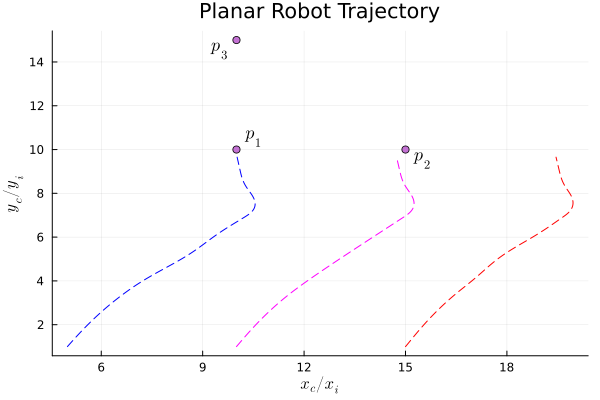

In [18]:
function plot_robots_trajectory(c, r, p)
  plot(c[:, 1], c[:, 2], ls=:dash, color=:magenta, label=["cluster"])
  plot!(r[:, 1], r[:, 2], ls=:dash, color=:blue, label=["robot 1"])
  plot!(r[:, 4], r[:, 5], ls=:dash, color=:red, label=["robot2"])

  annotate!([
    (p[1, 1] + 0.5, p[1, 2] + 0.5, text(L"p_1", 12)),
    (p[2, 1] + 0.5, p[2, 2] - 0.5, text(L"p_2", 12)),
    (p[3, 1] - 0.5, p[3, 2] - 0.5, text(L"p_3", 12))
  ])

  title!("Planar Robot Trajectory")
  xlabel!(L"x_c / x_i")
  ylabel!(L"y_c / y_i")

  scatter!(p[:, 1], p[:, 2], markershape=:circle, legend=false)
end

plot_robots_trajectory(c, r, goals)

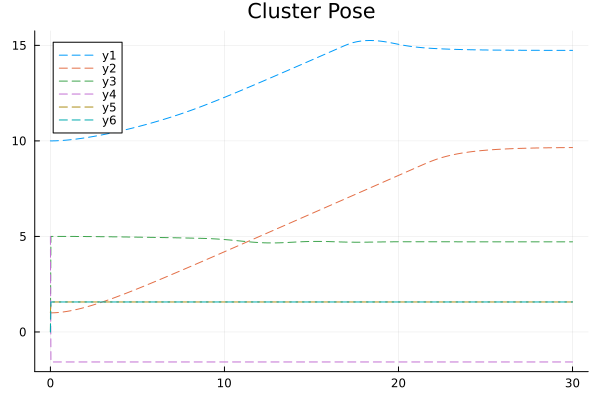

In [21]:
function plot_cluster_state(t, x)
  plot(t, x[:, 1], ls=:dash)

  title!("Cluster Pose")


  plot!(t, x[:, 2], ls=:dash)
  plot!(t, x[:, 3], ls=:dash)
  plot!(t, x[:, 4], ls=:dash)
  plot!(t, x[:, 5], ls=:dash)
  plot!(t, x[:, 6], ls=:dash)
end


function plot_task_effectiveness(t, δ)
  plot(t, δ[:, 1], ls=:dash, label=L"\delta_1")
  plot!(t, δ[:, 2], ls=:dash, label=L"\delta_2")
  title!("Task effectiveness")
  xlabel!("Time [s]")
  ylabel!(L"$\delta_i$")
  plot!(t, δ[:, 3], ls=:dash, label=L"\delta_3")
end
plot_cluster_state(t, c)

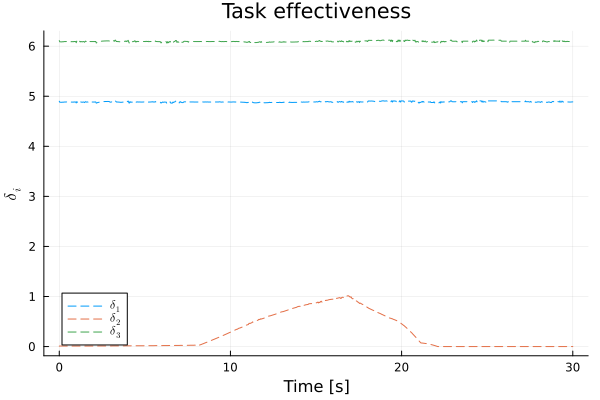

In [22]:
plot_task_effectiveness(t, slack)